# Capstone Project: Inventory Monitoring at Distribution Centers

Knowing exactly the count of a physical inventory has been a key issue in all industries that are involved in manufacturing and retail processes. Historically, this is a job that warehouse managers and supply chain professionals have performed through cycle counting, an audit process for managing inventory counts.

In this notebook, a solution for object counting based in Machine Learning,is presented. The solution uses the Pytorch framework available from AWS SageMaker. The goal is to deploy a SageMaker endpoint that will query images to get predictions about the number of objects in the submitted image.

In [1]:
# Install libraries required
!pip install smdebug
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [31]:
# Import libraries and packages

from tqdm import tqdm
import sagemaker

from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

role = sagemaker.get_execution_role()

## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. 

In [3]:
import os
import json
import boto3

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [4]:
download_and_arrange_data()

100%|██████████| 1228/1228 [01:34<00:00, 12.95it/s]


100%|██████████| 2299/2299 [03:05<00:00, 12.39it/s]


100%|██████████| 2666/2666 [03:42<00:00, 11.97it/s]


100%|██████████| 2373/2373 [03:17<00:00, 11.99it/s]


100%|██████████| 1875/1875 [02:30<00:00, 12.47it/s]


## Dataset

For this project, the [Amazon Bin Image Dataset](https://registry.opendata.aws/amazon-bin-imagery/) dataset is used, which contains over 500,000 container images and metadata from a pod in a working Amazon fulfillment center. Container images in this dataset are captured when robot units transport pods as part of normal Amazon Fulfillment Center operations. Since this is a large dataset, in order not to exceed the budget available for the project, a subset of the dataset has been used.

The subset consists of 10.441 images which were split into train and test datasets (80% of data were used for training and 20% of data for testing). The final distribution of classes is presented in the table below

Class|Description|Total number of images|Images for training|Images for testing|
|----|-----------|----------------------|-------------------|------------------|
|1|Bins with one object|1228|982|245|
|2|Bins with two objects|2299|1839|459|
|3|Bins with three objects|2666|2132|533|
|4|Bins with four objects|2373|1898|474|
|5|Bins with five objects|1875|1500|375|

In [47]:
import shutil
import random

os.makedirs("train")
os.makedirs("test")

for i in range(1,6):
    sf_path = os.path.join("train_data", str(i))
    train_sf = os.path.join("train", str(i))
    test_sf = os.path.join("test", str(i))
    os.makedirs(train_sf)
    os.makedirs(test_sf)

    images = []
    for image in os.listdir(sf_path):
        images.append(image)
        random.shuffle(images)
        train_images = images[:int(0.8 * len(images))]
        test_images = images[int(0.8 * len(images)):]

    for train_image in train_images:
        if train_image.endswith('.jpg'):
            src = os.path.join(sf_path, train_image)
            dst = os.path.join(train_sf, train_image)
            shutil.copy(src, dst)

    for test_image in test_images:
        if train_image.endswith('.jpg'):
            src = os.path.join(sf_path, test_image)
            dst = os.path.join(test_sf, test_image)
            shutil.copy(src, dst)

In [49]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix1 = "sagemaker/Final-Project/train"
prefix2 = "sagemaker/Final-Project/test"

train = sagemaker_session.upload_data(path="train", bucket=bucket, key_prefix=prefix1)
print("train: {}".format(train))

test = sagemaker_session.upload_data(path="test", bucket=bucket, key_prefix=prefix2)
print("test: {}".format(test))

train: s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train
test: s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test


## Model Training

The first model was trained with fixed hyperparameters, without hyperparameter tuning. A pre-trained ResNet50 model was used

In [17]:
hyperparameters = {
            "epochs": "1", 
            "batch-size": "64", 
            "lr": "0.05"
}

In [18]:
estimator = PyTorch(
    entry_point="train.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [19]:
estimator.fit(
    {
        "train":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train/",
        "test":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test/",
    }
) 

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-07-03-02-08-33-026


Using provided s3_resource
2023-07-03 02:08:33 Starting - Starting the training job...
2023-07-03 02:08:49 Starting - Preparing the instances for training......
2023-07-03 02:09:59 Downloading - Downloading input data......
2023-07-03 02:10:35 Training - Downloading the training image..................
2023-07-03 02:14:06 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-03 02:14:17,525 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-03 02:14:17,554 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-03 02:14:17,557 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-07-03 02:14:17,860 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": 

## Hyperparameter Tuning

In order to obtain better hyperparameters, that could lead to a better performance of the model, an hyperparameter tuning is executed. The three hyperparameters selected are:

### 1. Learning Rate:

The learning rate is one of the most important hyperparameter when a neural network is configurated. This parameter controls how much to change the model in response to the estimated error each time the model weights are updated. High values can lead the neural network to learn a sub-optimal set of weights or even to unstable training process. Low values can produce long training process that could get stuck. This is a continuos hyperparameter, the optimal value will be search in the range [0.01, 0.1]

### 2. Batch Size:

This parameter defines the number of training examples the network evaluates before updating the internal model parameters. Reducing the batch size will allow less memory usage during traininig process and a faster training, however the smaller the batch the less accurate the estimate of the gradient will be. A large batch size, or even all the sample data, which results in smooth converge to a deep, local minimum, but could require great amount of memory during the training. This is a categorical hyperparameter, the optimal value will be search within the follow values [32, 64, 128]

### 3. Epoch:

In terms of training process an epoch could be defined as a one forward pass and one backward pass of all the training examples. Small number of epochs results in underfitting, while too many epochs will lead to overfitting. This is a integer hyperparameter, the optimal value will be search in the range [1, 10]


In [2]:
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128]),
    "epochs": IntegerParameter(1, 10),
}

In [3]:
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([-3000-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [4]:
tuner.fit(
          {
            "train":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train/",
            "test":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test/",
          }
)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
..................................................................................................................................................................................................................................................................................................!


In [5]:
best_estimator = tuner.best_estimator()
best_estimator.hyperparameters()


2023-07-03 17:55:02 Starting - Found matching resource for reuse
2023-07-03 17:55:02 Downloading - Downloading input data
2023-07-03 17:55:02 Training - Training image download completed. Training in progress.
2023-07-03 17:55:02 Uploading - Uploading generated training model
2023-07-03 17:55:02 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'epochs': '10',
 'lr': '0.0769169840479485',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2023-07-03-17-32-31-194"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-553171274417/pytorch-training-2023-07-03-17-32-31-194/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging
Now, the best hyperparameters obtained from hyperparameter tuning process are used to train a new model. In this case, profiling and debugging are configured to monitor and debug the new training job.

In [32]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "10", "eval.save_interval": "1"}
)

collection_configs=[
    CollectionConfig(
        name="CrossEntropyLoss_output_0",
        parameters={
            "include_regex": "CrossEntropyLoss_output_0",
            "train.save_interval": "10",
            "eval.save_interval": "1"
        }
      )
    ]

hook_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [33]:
hyperparameters = {"epochs": "10", "batch-size": "64", "lr": "0.0769169840479485"}

estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name="smdebugger-final-pytorch",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [34]:
estimator.fit(
          {
            "train":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/train/",
            "test":"s3://sagemaker-us-east-1-553171274417/sagemaker/Final-Project/test/",
          }
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


Using provided s3_resource


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc

2023-07-03 22:12:25 Starting - Starting the training job...
2023-07-03 22:12:40 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LossNotDecreasing: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-07-03 22:13:52 Downloading - Downloading input data...
2023-07-03 22:14:24 Training - Downloading the training image.....................
2023-07-03 22:17:53 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-07-03 22:17:50,154 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-07-03 22:17:50,181 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-07-03 22:17:50,185 sagemaker_pytorch_container.training INFO     Invoking user training scr

In [35]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [36]:
job_name

'smdebugger-final-pytorch-2023-07-03-22-12-24-494'

In [38]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-07-03 22:34:15.497 ip-172-16-109-216.ec2.internal:7077 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/debug-output


In [39]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

[2023-07-03 22:34:37.420 ip-172-16-109-216.ec2.internal:7077 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-07-03 22:34:38.441 ip-172-16-109-216.ec2.internal:7077 INFO trial.py:210] Loaded all steps
loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


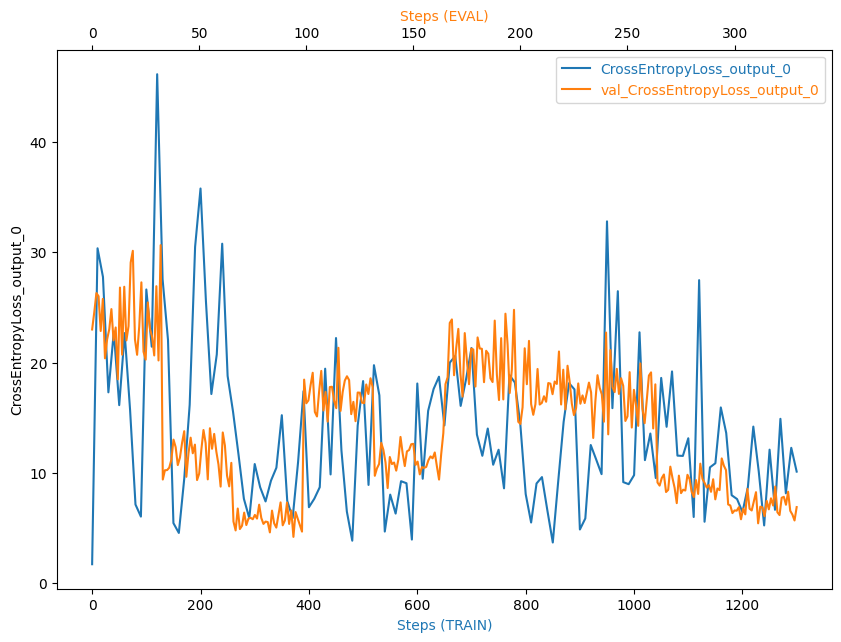

In [41]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [42]:
import boto3

session = boto3.session.Session()
region = session.region_name
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-553171274417/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/profiler-output


Profiler data from system is available


In [43]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

[2023-07-03 22:36:12.468 ip-172-16-109-216.ec2.internal:7077 INFO metrics_reader_base.py:134] Getting 20 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1'}


You will find the profiler report in s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output


In [44]:
! aws s3 ls {rule_output_path} --recursive

2023-07-03 22:32:46     426686 smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-07-03 22:32:45     283433 smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-07-03 22:32:40        192 smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-07-03 22:32:40      15106 smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-07-03 22:32:40       1917 smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-07-03 22:32:40        316 smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-07-03 22:32:40       1594 smdebugger-final-pytorch-2023-07-03-22-12-24-49

In [45]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-553171274417/smdebugger

In [46]:
import os

profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [47]:
from IPython.display import display, HTML

pdf_path = 'profiler-report.pdf'

html_code = f'<iframe src="{pdf_path}" width="100%" height="600px"></iframe>'

display(HTML(html_code))

### Model Deploying and Querying
Finally, an endpoint is deployed and a prediction is ran.

In [48]:
from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(framework_version=estimator.framework_version,
                             py_version=estimator.py_version,
                             model_data=estimator.model_data, 
                             role=role, 
                             entry_point='deployment.py')


predictor = pytorch_model.deploy(initial_instance_count=1,instance_type='ml.g4dn.xlarge')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-553171274417/smdebugger-final-pytorch-2023-07-03-22-12-24-494/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-553171274417/pytorch-inference-2023-07-03-22-38-48-700/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2023-07-03-22-38-56-317
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-07-03-22-38-57-063
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-07-03-22-38-57-063


---------!

In [61]:
# TODO: Run an prediction on the endpoint

from sagemaker.serializers import IdentitySerializer


predictor.serializer = IdentitySerializer("image/jpeg")
with open("00229.jpg", "rb") as f:
    image = f.read()

    
response = predictor.predict(image)


In [62]:
response.argmax()

1

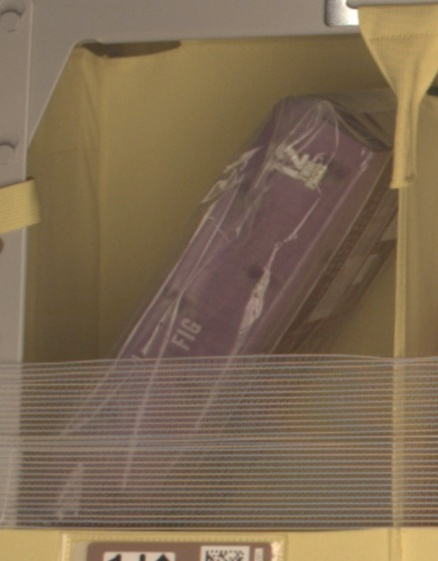

In [63]:
from PIL import Image
import io
Image.open(io.BytesIO(image))